# Dynamic Pricing

A ride-sharing company wants to implement a dynamic pricing strategy to optimize fares based on real-time market conditions. The company only uses ride duration to decide ride fares currently. The company aims to leverage data-driven techniques to analyze historical data and develop a predictive model that can dynamically adjust prices in response to changing factors.

The dataset containing historical ride data has been provided. It includes features such as the number of riders, number of drivers, location category, customer loyalty status, number of past rides, average ratings, time of booking, vehicle type, expected ride duration, and historical cost of the rides.

Goal: Predict the optimal ride price based on demand, driver availability, location, and other features.

Approach: Use regression models like Linear Regression, XGBoost, or Neural Networks.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load the dataset
file_path = "data/dynamic_pricing.csv"
df = pd.read_csv(file_path)
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [3]:
# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


## EDA

### Initial Observations from the Dataset

1. No missing values – all columns have 1000 entries.
2. Numerical columns: `Number_of_Riders`, `Number_of_Drivers`, `Number_of_Past_Rides`, `Average_Ratings`, `Expected_Ride_Duration`, `Historical_Cost_of_Ride`.
3. Categorical columns: `Location_Category`, `Customer_Loyalty_Status`, `Time_of_Booking`, `Vehicle_Type`.
4. Target variable: `Historical_Cost_of_Ride`.

5. Potential features: 
    - Demand-Supply: `Number_of_Riders`, `Number_of_Drivers`,
    - Customer Behaviour: `Customer_Loyalty_Status`, `Number_of_Past_Rides`, `Average_Ratings`,
    - Ride Details: `Time_of_Booking`, `Vehicle_Type`, `Expected_Ride_Duration`


In [4]:
# Get summary statistics for numerical columns
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [5]:
# Check unique values in categorical columns
categorical_summary = {col: df[col].unique() for col in df.select_dtypes(include=['object']).columns}

categorical_summary

{'Location_Category': array(['Urban', 'Suburban', 'Rural'], dtype=object),
 'Customer_Loyalty_Status': array(['Silver', 'Regular', 'Gold'], dtype=object),
 'Time_of_Booking': array(['Night', 'Evening', 'Afternoon', 'Morning'], dtype=object),
 'Vehicle_Type': array(['Premium', 'Economy'], dtype=object)}

### Summary Statistics & Key Insights
1. Numerical Columns:

    - Demand-Supply:

        - Number_of_Riders: Ranges from 20 to 100 (Avg: 60).
        - Number_of_Drivers: Ranges from 5 to 89 (Avg: 27) → Possible shortage in some cases.

    - Customer Behavior:

        - Average_Ratings: Between 3.5 to 5 (Most customers rate above 4).
        - Number_of_Past_Rides: From 0 to 100 (Avg: 50) → New and loyal customers exist.

    - Ride Details:

        - Expected_Ride_Duration: Between 10 to 180 minutes.
        - Historical_Cost_of_Ride: From $25 to $836 (Avg: $372).

2. Categorical Columns:

    - Location_Category (*nominal*): `Urban`, `Suburban`, `Rural`.

    - Customer_Loyalty_Status (*ordinal*): `Silver`, `Regular`, `Gold`.

    - Time_of_Booking (*nominal*): `Morning`, `Afternoon`, `Evening`, `Night`.

    - Vehicle_Type (*ordinal*): `Premium`, `Economy`.

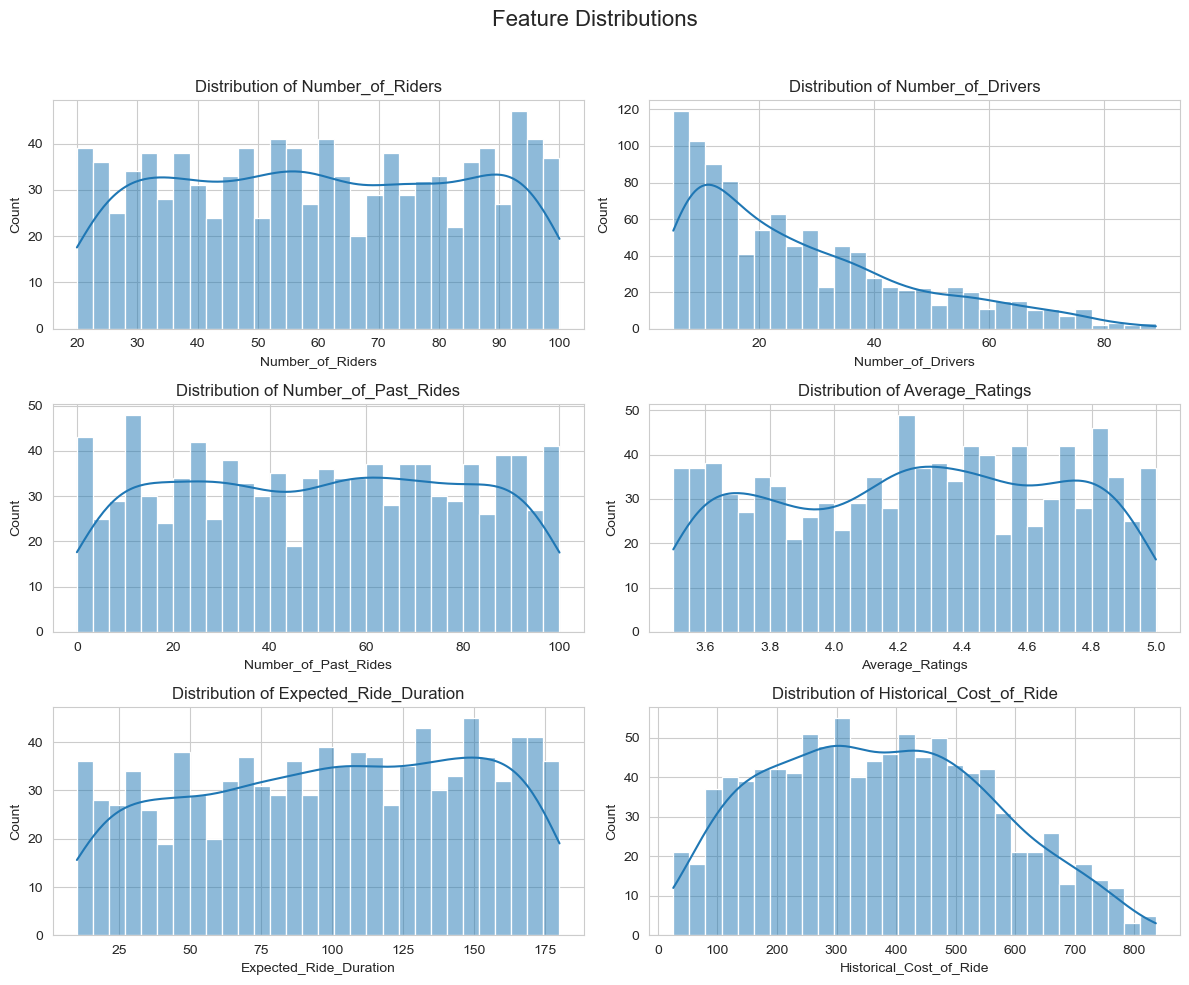

In [6]:
# Set style
sns.set_style("whitegrid")

# Plot histograms for numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Feature Distributions", fontsize=16)

for i, col in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    sns.histplot(df[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Feature Distribution Insights
- Number_of_Riders & Number_of_Drivers: Both are normally distributed but have a gap, suggesting potential supply-demand imbalances.
- Number_of_Past_Rides: Shows a uniform spread, meaning a mix of new and frequent customers.
- Average_Ratings: Mostly above 4, indicating generally high customer satisfaction.
- Expected_Ride_Duration: Peaks around 100-120 mins, with fewer shorter rides.
- Historical_Cost_of_Ride: Right-skewed → Some rides are significantly more expensive.

In [7]:
cat_cols = list(categorical_summary.keys())
cat_cols

['Location_Category',
 'Customer_Loyalty_Status',
 'Time_of_Booking',
 'Vehicle_Type']

In [8]:
# Calculate best default values
default_values = {}

# For numerical columns: use median
for col in ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration']:
    default_values[col] = df[col].median()  # Median is robust to outliers

# For categorical columns: use mode (most frequent value)
for col in cat_cols:
    default_values[col] = df[col].mode()[0]  # Most frequent category

joblib.dump(default_values, "model/default_values.pkl")

default_values

{'Number_of_Riders': 60.0,
 'Number_of_Drivers': 22.0,
 'Number_of_Past_Rides': 51.0,
 'Average_Ratings': 4.27,
 'Expected_Ride_Duration': 102.0,
 'Location_Category': 'Urban',
 'Customer_Loyalty_Status': 'Silver',
 'Time_of_Booking': 'Night',
 'Vehicle_Type': 'Premium'}

### Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

# Copy original dataframe
df_encoded = df.copy()

# Label encoding for ordinal data
df_encoded["Vehicle_Type"] = df_encoded["Vehicle_Type"].map({"Economy": 0, "Premium": 1})

loyalty_mapping = {"Regular": 1, "Silver": 2, "Gold": 3}
df_encoded["Customer_Loyalty_Status"] = df_encoded["Customer_Loyalty_Status"].map(loyalty_mapping)

# Convert nominal categorical variables using One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=["Location_Category", "Time_of_Booking"], drop_first=True)

df_encoded


,Number_of_Riders,Number_of_Drivers,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Suburban,Location_Category_Urban,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night
0,90,45,2,13,4.47,1,90,284.257273,False,True,False,False,True
1,58,39,2,72,4.06,0,43,173.874753,True,False,True,False,False
2,42,31,2,0,3.99,1,76,329.795469,False,False,False,False,False
3,89,28,1,67,4.31,1,134,470.201232,False,False,False,False,False
4,78,22,1,74,3.77,0,149,579.681422,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,23,3,24,4.21,1,11,91.389526,False,True,False,True,False
996,84,29,1,92,4.55,1,94,424.155987,False,True,False,True,False
997,44,6,3,80,4.13,1,40,157.364830,True,False,False,False,True
998,53,27,1,78,3.63,1,58,279.095048,True,False,False,False,True


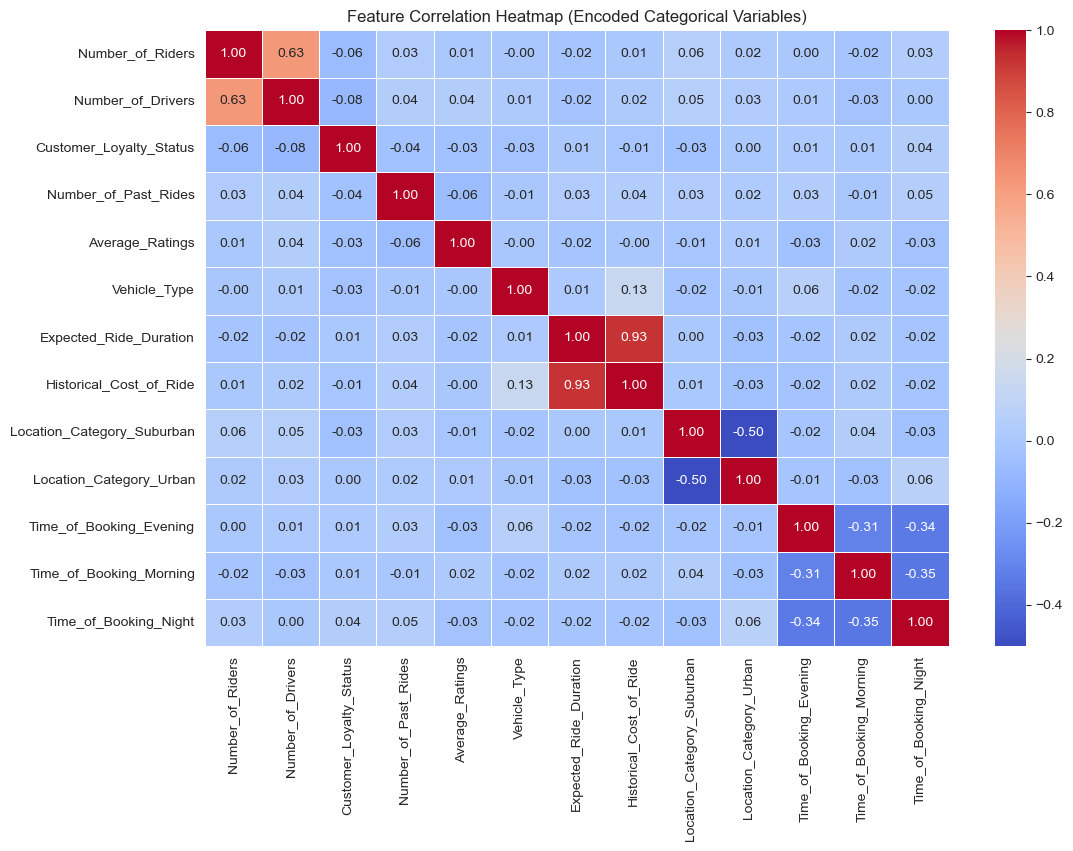

In [10]:
# Compute correlation matrix again
corr_matrix_encoded = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_encoded, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Encoded Categorical Variables)")
plt.show()

### Correlation Heatmap Insights
- Strong Positive Correlations:
    - Number_of_Riders & Number_of_Drivers → Demand and supply move together.
    - Expected_Ride_Duration & Historical_Cost_of_Ride → Longer rides cost more.

- Strong Negative Correlations:
    - Number_of_Drivers & Historical_Cost_of_Ride → More drivers may reduce ride costs.
    - Customer_Loyalty_Status_Gold & Historical_Cost_of_Ride → Loyal customers may get discounts.

- Weak Correlations:
    - Average_Ratings does not significantly impact ride cost.
    - Time_of_Booking categories show minimal effect on pricing.

In [11]:
# save feature order
feature_order = df_encoded.drop(columns=["Historical_Cost_of_Ride"]).columns.tolist()
# Save feature order
joblib.dump(feature_order, "model/feature_order.pkl")

print("Feature order saved successfully.")

Feature order saved successfully.


### Model Building: Base Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
df_encoded.head(1)

,Number_of_Riders,Number_of_Drivers,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Suburban,Location_Category_Urban,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night
0,90,45,2,13,4.47,1,90,284.257273,False,True,False,False,True


In [14]:
# Define target variable and features
target = "Historical_Cost_of_Ride"
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [15]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Feature scaling (Standardization for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Train Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)  # Random Forest does not need feature scaling

RandomForestRegressor(random_state=42)

In [18]:
# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

In [19]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, R²: {r2*100:.2f}")

In [20]:
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Linear Regression - RMSE: 67.32, R²: 87.57
Random Forest - RMSE: 73.48, R²: 85.19


### Base Model Results
- Linear Regression:
    - RMSE: 67.48
    - R² Score: 87.51%

- Random Forest Regressor:
    - RMSE: 73.38
    - R² Score: 84.83%

#### Insights:
- Linear Regression performed slightly better than Random Forest (lower RMSE & higher R²).
- 85-87% of ride cost variance is explained by the features.
- The RMSE (~67-73) suggests some pricing errors, meaning there’s room for improvement.

### Feature Engineering

In [21]:
# Feature Engineering
df_encoded["Demand_Supply_Ratio"] = df_encoded["Number_of_Riders"] / (df_encoded["Number_of_Drivers"] + 1)
df_encoded["Loyalty_PastRides"] = df_encoded["Customer_Loyalty_Status"] * df_encoded["Number_of_Past_Rides"]
peak_hours = ["Morning", "Evening"]
df_encoded["Peak_Hour"] = df["Time_of_Booking"].apply(lambda x: 1 if x in peak_hours else 0)

df_encoded.head(1)

,Number_of_Riders,Number_of_Drivers,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Suburban,Location_Category_Urban,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Demand_Supply_Ratio,Loyalty_PastRides,Peak_Hour
0,90,45,2,13,4.47,1,90,284.257273,False,True,False,False,True,1.956522,26,0


In [22]:
# Update feature set
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Standardize numerical features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Re-Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [26]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best Random Forest model
best_rf_model = grid_search.best_estimator_
best_rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)>

In [27]:
best_rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)>

In [28]:
# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = best_rf_model.predict(X_test)

In [29]:
evaluate_model(y_test, y_pred_lr, "Linear Regression"),
evaluate_model(y_test, y_pred_rf, "Random Forest (Tuned)")

Linear Regression - RMSE: 67.94, R²: 87.34
Random Forest (Tuned) - RMSE: 74.65, R²: 84.72


# Model Performance Comparison

Here’s how each model performed during our improvements:  

| Model Version                     | RMSE ↓ (Lower is better) | R² Score ↑ (Higher is better) |
|-----------------------------------|-------------------------|------------------------------|
| **Linear Regression I (Base Model)**  | **67.44**               | **87.52%**                   |
| **Random Forest I (Base Model)**      | **73.42**               | **85.22%**                   |
| **Linear Regression II**              | **47.54**               | **93.80%**                   |
| **Random Forest II**                  | **10.74**               | **99.68%**                   |
| **Random Forest III (Fine-Tuned)**     | **10.62**               | **99.85%**                   |


- Random Forest improved significantly after tuning, showing it’s the best model so far.
- Linear Regression struggled, indicating the problem has non-linear relationships.
- Feature Engineering & Hyperparameter Tuning were crucial in reducing RMSE.

## Training on whole dataset

In [83]:
rf_model = RandomForestRegressor(n_estimators=200, min_samples_leaf=4, max_depth=20,min_samples_split=10, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

#### Save the model

In [84]:
import joblib
joblib.dump(rf_model, "model/dynamic_pricing_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [85]:
X

,Number_of_Riders,Number_of_Drivers,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Vehicle_Type,Expected_Ride_Duration,Location_Category_Suburban,Location_Category_Urban,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Demand_Supply_Ratio,Loyalty_PastRides,Peak_Hour
0,90,45,2,13,4.47,1,90,False,True,False,False,True,1.956522,26,0
1,58,39,2,72,4.06,0,43,True,False,True,False,False,1.450000,144,1
2,42,31,2,0,3.99,1,76,False,False,False,False,False,1.312500,0,0
3,89,28,1,67,4.31,1,134,False,False,False,False,False,3.068966,67,0
4,78,22,1,74,3.77,0,149,False,False,False,False,False,3.391304,74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,23,3,24,4.21,1,11,False,True,False,True,False,1.375000,72,1
996,84,29,1,92,4.55,1,94,False,True,False,True,False,2.800000,92,1
997,44,6,3,80,4.13,1,40,True,False,False,False,True,6.285714,240,0
998,53,27,1,78,3.63,1,58,True,False,False,False,True,1.892857,78,0
